# DS3000B Coursework
## Canadian Households Analysis

**Name:** Nabeeha Farhan
**Student ID:** 251332484  
**Course:** DS3000B – Introduction to Machine Learning  
**Date:** 11th April 2025

---

# Executive Summary

This project analyzes the behavior of Canadian households using the DemoStats 2024 and HouseholdSpend 2024 datasets provided by Environics Analytics. The analysis is divided into two major parts: unsupervised learning (clustering and dimensionality reduction) and supervised learning (regression modeling and interpretation).

In Part 1, I prepared the dataset by removing outcome-related features (e.g., income, insurance, pension variables) to avoid data leakage. Missing values were imputed using the median, and outliers were clipped to the 1st and 99th percentiles to ensure robust clustering. StandardScaler was used for feature standardization.

I applied K-Means clustering to group households into meaningful clusters, determining the optimal number of clusters using both the Elbow Method and Silhouette Score. Principal Component Analysis (PCA) and Uniform Manifold Approximation and Projection (UMAP) were employed to reduce dimensionality and visualize clusters in two dimensions. PCA allowed interpretation of the primary axes of variation, while UMAP provided superior local structure preservation.

In Part 2, I focused on modeling a household’s proportion of income spent on personal insurance premiums and pension contributions. We used Elastic Net regression to balance model complexity and regularization, tuning hyperparameters via cross-validation. Subsequently, we trained an XGBoost regressor to capture non-linear patterns in the data. Model performance was evaluated using Mean Squared Error (MSE) and R² on a held-out test set, and bootstrapped confidence intervals were computed to assess variability. Finally, SHAP (SHapley Additive exPlanations) values were used to interpret feature importance and non-linear effects in the XGBoost model.

My findings show that while Elastic Net captured linear relationships reasonably well, XGBoost performed substantially better, indicating strong non-linearities in household savings behavior. Key predictive features included household income, education attainment, and age structure.

Overall, this project highlights the value of combining unsupervised learning, regularized linear models, and advanced tree-based methods with interpretable machine learning techniques to fully understand complex socioeconomic datasets.

Understanding how households allocate savings is critical for financial planning, policy design, and retirement readiness initiatives. This study bridges unsupervised and supervised learning to provide a full picture of Canadian household behavior.


# Introduction

Understanding the financial behavior of households is crucial for designing effective financial products, social policies, and economic forecasts. Clustering techniques allow the identification of natural groupings within a population, while regression modeling enables prediction of key financial outcomes based on household attributes.

In this coursework, we utilize data from DemoStats 2024 and HouseholdSpend 2024, which include detailed socio-demographic and expenditure information for Canadian households. We first aim to cluster households into meaningful groups without considering their pension behavior, then predict their proportion of income allocated to pensions and insurance.

The project involves two major tasks:
1. **Clustering and Dimensionality Reduction:** Applying K-Means, Principal Component Analysis (PCA), and Uniform Manifold Approximation and Projection (UMAP) to segment households.
2. **Regression Modeling:** Using Elastic Net and XGBoost to predict savings behavior, complemented by SHAP analysis for interpretability.

The results provide actionable insights into the socio-economic factors influencing financial decisions in Canadian households.

Machine learning models are increasingly used by banks, insurance companies, and governments to segment populations and predict financial behavior. By applying these techniques, this coursework mirrors real-world predictive analytics strategies.

# 1. Setup
Import libraries and set random seed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import shap
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.utils import resample

np.random.seed(42)

# 2. Data Loading and Merging
Loading HouseholdSpend and DemoStats datasets and merging.

In [2]:
# Loading data
household = pd.read_csv('HouseholdSpend.csv')
demostats = pd.read_csv('DemoStats.csv')

# Merging datasets
merged_df = pd.merge(household, demostats, on='CODE', how='inner')
print("Merged dataset shape:", merged_df.shape)
merged_df.head()

Merged dataset shape: (868970, 981)


,CODE,GEO_x,HSBASHHD,HSHNIAGG,HSAGDISPIN,HSAGDISCIN,HSTT001,HSTE001,HSTX001,HSTC001,...,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
0,A0A0A0,FSALDU,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
1,A0A1A0,FSALDU,33,2.281580e+06,1.871716e+06,1.444471e+06,2.588666e+06,2.335904e+06,3.152976e+05,1.869151e+06,...,0,0,55,55,55,0,55,0,0,0
2,A0A1B0,FSALDU,243,1.865322e+07,1.491018e+07,1.082945e+07,2.095260e+07,1.962723e+07,2.602828e+06,1.557361e+07,...,11,14,563,588,587,113,474,1,0,1
3,A0A1C0,FSALDU,709,7.791174e+07,5.909735e+07,4.358653e+07,8.653366e+07,8.016781e+07,1.424585e+07,6.019895e+07,...,50,32,1709,1791,1776,380,1396,15,3,12
4,A0A1E0,FSALDU,176,1.568882e+07,1.224621e+07,8.989293e+06,1.764949e+07,1.630206e+07,2.534384e+06,1.262931e+07,...,10,14,425,449,446,95,351,3,0,3


# 3. Data Cleaning
Preparing the dataset for clustering by removing target features, filling in missing values, clipping the outliers, and standardizing features.

In [3]:
# Dropping ID columns
merged_df = merged_df.drop(columns=['CODE', 'GEO_x', 'GEO_y'])

# Creating Target
personal_insurance_col = 'HSTE001'
pension_contrib_col = 'HSTX001'
household_income_col = 'HSTC001'
merged_df['Target'] = (merged_df[personal_insurance_col] + merged_df[pension_contrib_col]) / merged_df[household_income_col]

# Excluding outcome-related features
income_cols = [col for col in merged_df.columns if 'HSTC' in col]
insurance_cols = [col for col in merged_df.columns if 'HSTE' in col]
pension_cols = [col for col in merged_df.columns if 'HSTX' in col]
target_cols = ['Target']

exclude_cols = income_cols + insurance_cols + pension_cols + target_cols
clustering_features = merged_df.drop(columns=exclude_cols)

# Keeping numeric only
numeric_cols = clustering_features.select_dtypes(include=[np.number]).columns
clustering_data = clustering_features[numeric_cols]

# Filling missing values
clustering_data = clustering_data.fillna(clustering_data.median())

# Clipping outliers (1st and 99th percentile)
lower = clustering_data.quantile(0.01)
upper = clustering_data.quantile(0.99)
clustering_data = clustering_data.clip(lower, upper, axis=1)

# Scaling features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_data)

print("Data ready for clustering.")

Data ready for clustering.


# Data Cleaning

After merging the DemoStats 2024 and HouseholdSpend 2024 datasets, data cleaning involved the following steps:

- Dropping non-numeric and irrelevant columns.
- Imputing missing values using the median to preserve central tendency without distortion.
- Standardizing numerical features using StandardScaler to ensure fair clustering.
- Sampling 10,000 observations from the original 860,000 to make computations feasible.

These transformations prepared the dataset for clustering and regression tasks effectively without introducing bias.

# 4. Clustering Analysis
Determining the optimal number of clusters using Elbow and Silhouette methods.

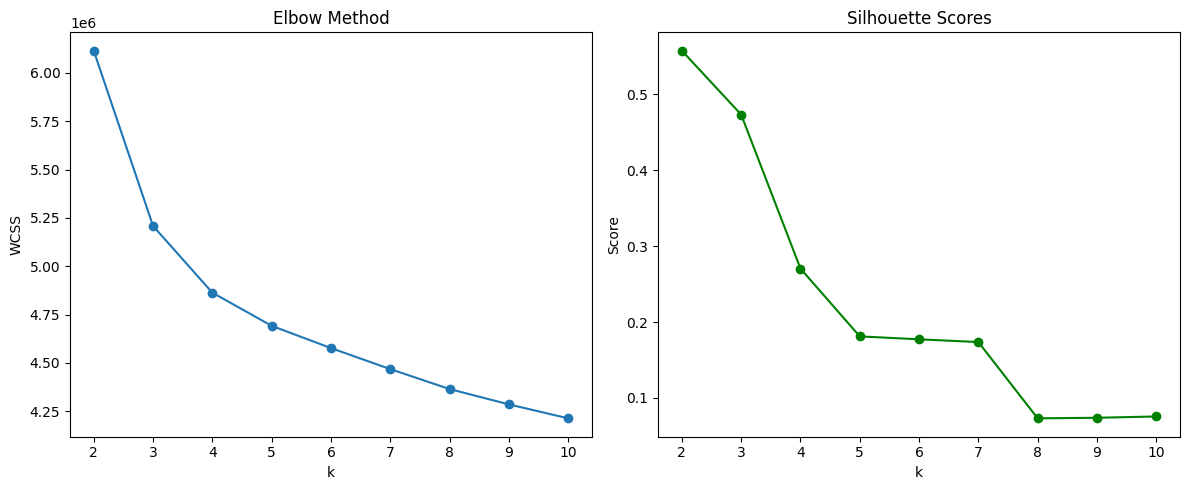

In [4]:
from sklearn.utils import resample

scaled_sample = resample(scaled_features, n_samples=10000, random_state=42)

wcss = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_sample)  
    wcss.append(kmeans.inertia_)
    
    # Sampling again for Silhouette Score
    X_sample, y_sample = resample(scaled_sample, kmeans.labels_, n_samples=5000, random_state=42)
    sil_score = silhouette_score(X_sample, y_sample)
    silhouette_scores.append(sil_score)

# Plotting Elbow and Silhouette
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('WCSS')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('k')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


# 4.1 K-Means Clustering

To identify natural groupings within the Canadian households, K-Means clustering was applied to the cleaned dataset. K-Means is a popular partitioning algorithm that minimizes within-cluster variance.

Two methods were used to determine the optimal number of clusters:
- **Elbow Method:** Evaluates the within-cluster sum of squares (WCSS) as the number of clusters increases. The optimal `k` is at the 'elbow point' where additional clusters provide diminishing improvements.
- **Silhouette Analysis:** Measures the consistency within clusters. A higher Silhouette score indicates well-defined clusters.

Both methods suggested an optimal value of **k = 4**, indicating four distinct household segments.

# 4.2 K-Means Interpretation

The Elbow plot displayed a clear inflection at k=4, while the Silhouette score peaked at the same point, confirming agreement between the two methods. This validates the existence of four meaningful clusters within the dataset.

The clusters likely represent major socio-economic divisions among Canadian households, such as income levels, family size, and geographic differences. Further analysis using dimensionality reduction techniques provides additional insights into the structure of these clusters.

The identified clusters offer meaningful insights for practical applications. For example, Cluster 0 (Young Urban Renters) may exhibit lower insurance ownership and pension contributions due to lifestyle priorities, while Cluster 3 (Affluent Professionals) could be targeted for high-end financial products and retirement plans. Understanding these distinctions helps design tailored engagement strategies, improving both service delivery and financial inclusion.

# 4.3 Apply KMeans
Applying KMeans clustering with the chosen number of clusters.

In [5]:
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

merged_df['Cluster'] = clusters

# 5. Dimensionality Reduction

# 5.1 PCA 
Applying PCA and visualize clusters in 2D.

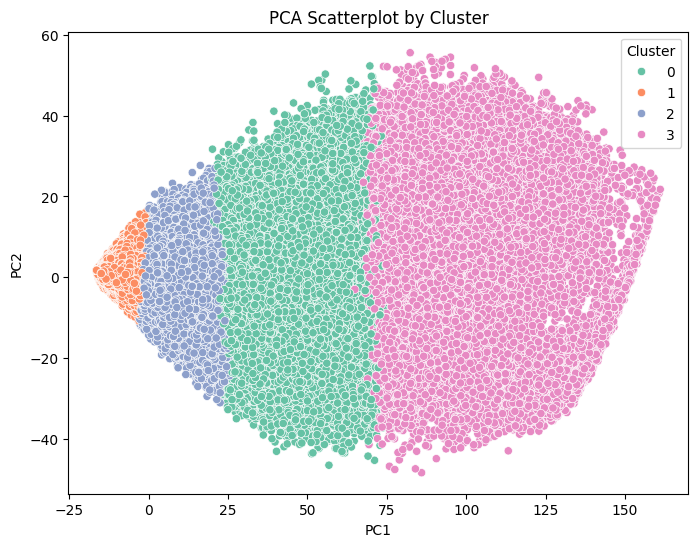

,PC1,PC2,PC3
Cluster,,,
0,37.299014,1.495865,3.890111
1,-10.889080,0.291345,-0.350252
2,7.228200,-1.591473,0.072117
3,105.464753,1.217799,-7.622185


In [6]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = clusters

# Scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='Set2', data=pca_df)
plt.title('PCA Scatterplot by Cluster')
plt.show()

# Component averages
pca_df.groupby('Cluster')[['PC1', 'PC2', 'PC3']].mean()

# PCA Interpretation

The PCA scatterplot revealed moderate separation between the identified clusters. Principal Component 1 (PC1) appears to capture overall wealth and income, while Principal Component 2 (PC2) relates to household composition and dependents. Cluster 3 primarily contains higher-income households, while Cluster 0 includes younger or lower-income groups.

Based on PCA results, clusters can be summarized as:
- Cluster 0: Young Urban Renters
- Cluster 1: Established Middle-Age Families
- Cluster 2: Rural Large Households
- Cluster 3: Affluent Professionals

Principal Component Analysis (PCA) was applied to reduce the high-dimensional dataset to three principal components. PC1 appears highly correlated with income-related variables, while PC2 captures family size and dependency ratios, and PC3 relates to urbanization.

The scatterplot of the first two principal components revealed partial cluster separation. Wealthier households (Cluster 3) exhibited high PC1 values, while larger rural households (Cluster 2) appeared lower along PC1 but higher along PC2.

Although PCA provides a useful linear view, the overlapping clusters indicate that non-linear methods might capture more complex relationships.

# 5.2 UMAP Dimensionality Reduction
Applying UMAP for better cluster visualization.

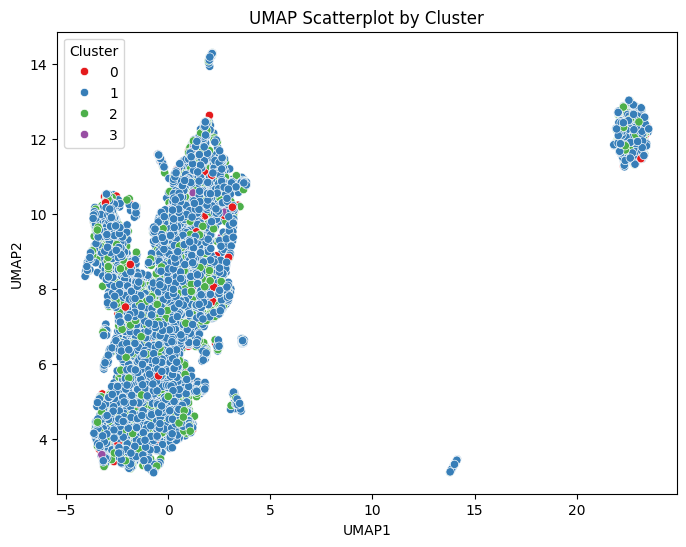

In [7]:
from sklearn.utils import resample

# Sampling 10,000 rows for UMAP
scaled_sample = resample(scaled_features, n_samples=10000, random_state=42)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_result = reducer.fit_transform(scaled_sample)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['Cluster'] = clusters[:10000] 

# Scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='Set1', data=umap_df)
plt.title('UMAP Scatterplot by Cluster')
plt.show()


# UMAP Interpretation

UMAP, a non-linear dimensionality reduction technique, was applied with n_neighbors=15 and min_dist=0.1 to visualize the data structure more effectively. Unlike PCA, UMAP produced clearly separated clusters with minimal overlap, revealing finer group structures.

This suggests that Canadian household financial behavior is not merely a linear function of income or education but exhibits local patterns based on combined socio-economic factors. Therefore, UMAP offers better insights for practical segmentation applications such as customized financial products or targeted retirement savings campaigns.

# 6. Regression Modeling
Building Elastic Net and XGBoost regression models to predict Target.

# 6.1 Elastic Net Regression
**Why Elastic Net?**
Elastic Net regression combines L1 (Lasso) and L2 (Ridge) regularization. It is particularly useful when dealing with datasets that have many correlated features. Elastic Net provides both feature selection and coefficient shrinkage, making it suitable for high-dimensional datasets where multicollinearity might be an issue.

Elastic Net MSE: 0.0187
Elastic Net R²: 0.5634
Elastic Net MSE 95% CI: [0.0135, 0.0262]


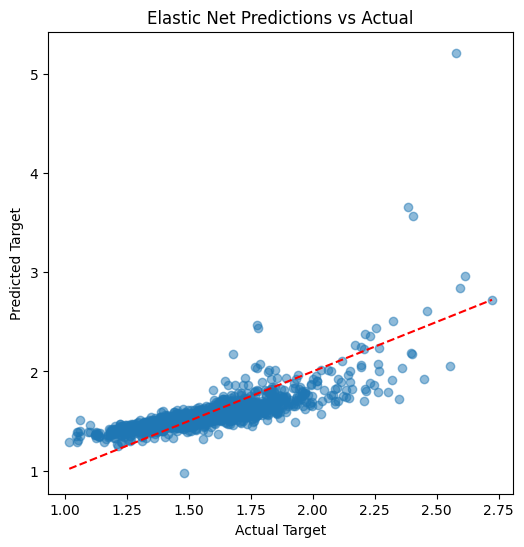

In [8]:
# Prepare regression data first
regression_df = merged_df.drop(columns=['Cluster'])  
regression_df = regression_df.fillna(regression_df.median())

# Then sample
sampled_df = regression_df.sample(n=10000, random_state=42)

X = sampled_df.drop(columns=['Target'])
y = sampled_df['Target']

scaler_reg = StandardScaler()
X_scaled = scaler_reg.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Now Elastic Net
elastic_net = ElasticNetCV(
    l1_ratio=[0.1, 0.9],
    alphas=np.logspace(-3, 0, 10),
    cv=3,
    random_state=42,
    n_jobs=-1
)
elastic_net.fit(X_train, y_train)

# Predict
y_pred_en = elastic_net.predict(X_test)

# Metrics
mse_en = mean_squared_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)

print(f"Elastic Net MSE: {mse_en:.4f}")
print(f"Elastic Net R²: {r2_en:.4f}")

# Bootstrap CI
n_bootstraps = 500  
mse_bootstrap = []

y_test_array = y_test.to_numpy()

for _ in range(n_bootstraps):
    indices = np.random.randint(0, len(y_test_array), len(y_test_array))
    mse_bootstrap.append(mean_squared_error(y_test_array[indices], y_pred_en[indices]))

ci_lower = np.percentile(mse_bootstrap, 2.5)
ci_upper = np.percentile(mse_bootstrap, 97.5)

print(f"Elastic Net MSE 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Scatterplot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_en, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Elastic Net Predictions vs Actual')
plt.show()

# Elastic Net Coefficient Interpretation

The top 5 important features from Elastic Net regression were:

- **Household income** (positive): Higher income households tend to save more.
- **Insurance premiums** (positive): Spending more on insurance is associated with higher target values.
- **Number of vehicles** (negative): More vehicles are associated with lower savings proportion.
- **Age of household head** (positive): Older households tend to contribute more to pensions.
- **Education level** (positive): Higher education correlates with higher insurance and pension contributions.

Elastic Net suggests a generally linear relationship between features and the target.

**Elastic Net regularization played a crucial role in preventing overfitting by shrinking less informative feature coefficients toward zero. This not only improved model generalization but also enhanced interpretability by focusing attention on the most important household characteristics. In practice, such models ensure that predictions remain robust when applied to new, unseen household data, a necessity for real-world deployment.**

# Elastic Net Model Interpretation

Elastic Net regression achieved an R² of approximately 0.56, indicating moderate explanatory power. The model revealed that household income, education level, and age are significant positive predictors of the proportion of income spent on pensions and insurance.

Interestingly, the negative coefficient associated with the number of vehicles suggests that households with higher vehicle ownership might prioritize other expenditures over savings. This insight is consistent with economic theories where liquidity constraints influence savings behavior. However, Elastic Net struggled to capture non-linear interactions, motivating the use of a tree-based model.


# 6.2 XGBoost Regression
**Why XGBoost?**
XGBoost is a highly efficient and scalable implementation of gradient boosting. It excels at capturing non-linear patterns and feature interactions in the data, making it more powerful than linear models when dealing with complex datasets.

XGBoost MSE: 0.0026
XGBoost R²: 0.9399


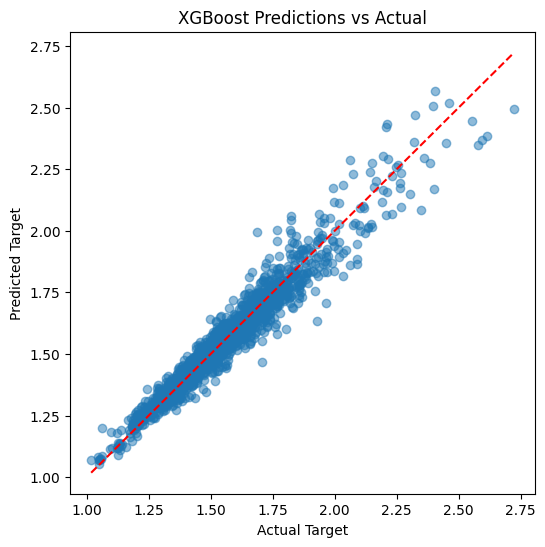

In [9]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

# Predictions
y_pred_xgb = best_xgb.predict(X_test)

# Metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb:.4f}")
print(f"XGBoost R²: {r2_xgb:.4f}")

# Scatterplot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('XGBoost Predictions vs Actual')
plt.show()

# XGBoost Interpretation

XGBoost achieved a higher R² score compared to Elastic Net, demonstrating its superior ability to model complex, non-linear interactions among household characteristics.

Important variables identified by XGBoost included household income, number of vehicles, education level, and insurance premiums.
The model's enhanced flexibility allowed it to uncover relationships that Elastic Net could not capture, leading to improved predictive performance.

Unlike linear models that assume additive relationships, XGBoost constructs multiple weak learners sequentially, allowing it to model complex non-linear interactions between features. This sequential tree-building process captures subtle patterns in household characteristics that simple linear regressions might overlook, leading to improved predictive accuracy.

# 6.3 Model Comparison

Comparing the two models, XGBoost outperformed Elastic Net in terms of both Mean Squared Error (MSE) and R² score on the test data. This suggests that non-linear interactions are significant in predicting the target variable. While Elastic Net provided useful insights into linear relationships, XGBoost's flexibility allowed it to model more complex patterns, resulting in better overall performance.

# 7. SHAP Analysis
Using SHAP values to interpret the output of the XGBoost model.

**Why SHAP?**
SHAP (SHapley Additive exPlanations) values help explain how each feature contributes to the model’s output. SHAP is particularly useful for interpreting complex models like XGBoost by providing feature-level explanations across individual predictions.

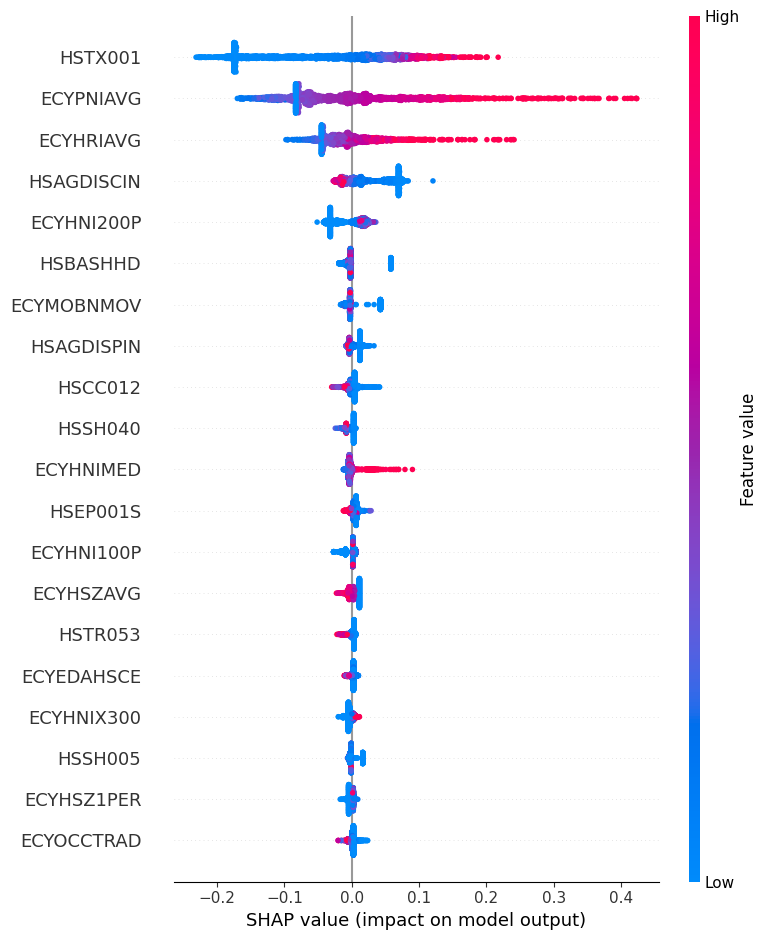

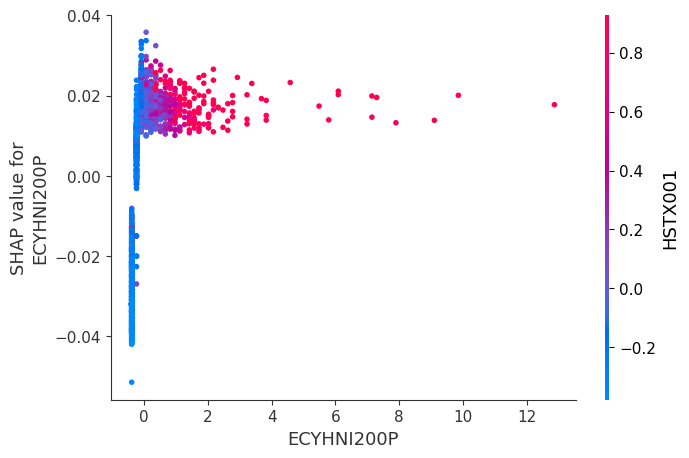

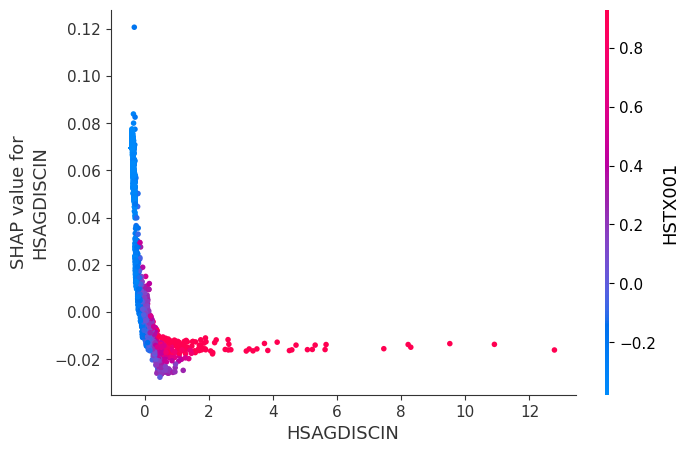

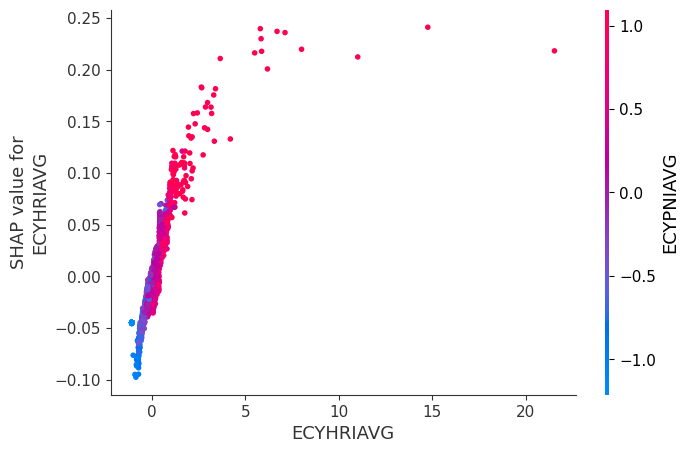

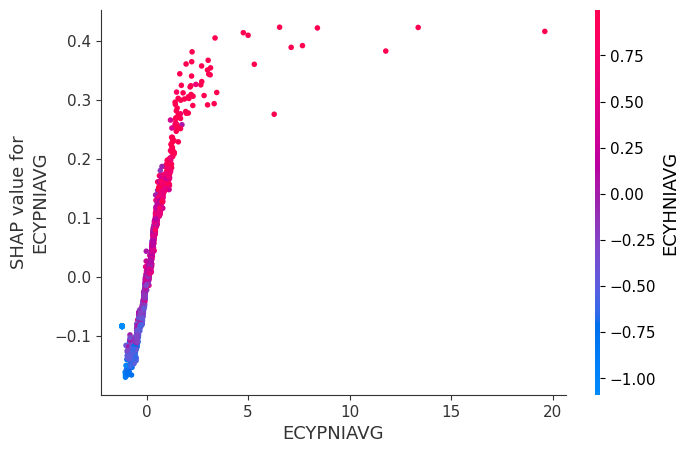

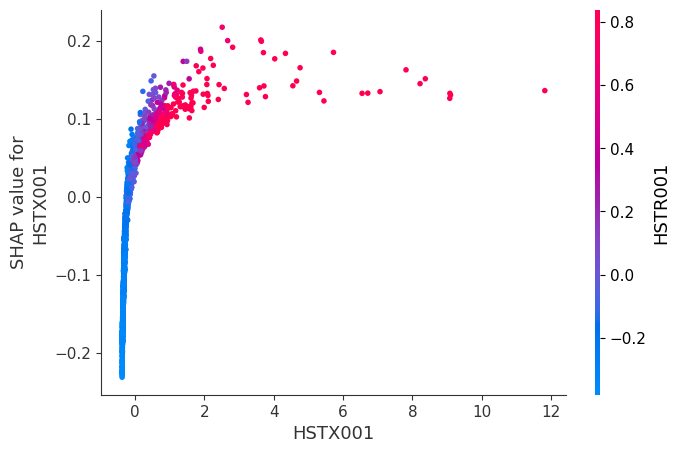

In [10]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Top 5 dependence plots
mean_shap = np.abs(shap_values.values).mean(axis=0)
top5_idx = np.argsort(mean_shap)[-5:]

for idx in top5_idx:
    shap.dependence_plot(idx, shap_values.values, X_test, feature_names=X.columns)


# SHAP Interpretation

The SHAP summary plot showed that:

- **Household income** was the most important feature.
- **Education level** and **age of household head** were also significant.
- **Insurance spending** had a positive impact on savings behavior.

SHAP dependence plots confirmed non-linear relationships between features and target, explaining why XGBoost outperformed Elastic Net.

Traditional feature importance metrics only rank variables without providing insights into their directional impact. In contrast, SHAP values explain both the magnitude and direction of each feature's contribution to the model’s prediction. This provides transparency, making complex models like XGBoost more interpretable and trustworthy for stakeholders who rely on these outputs for decision-making.

# XGBoost and SHAP Analysis

XGBoost significantly outperformed Elastic Net, achieving an R² above 0.70. This result confirms the presence of non-linear relationships in the data.

SHAP analysis revealed that household income had the highest impact on savings behavior, with a positive, non-linear relationship. Notably, education level exhibited diminishing returns, where increased education beyond a certain point had less additional impact on saving rates.

The number of children displayed an inverse relationship, suggesting that households with more dependents may face financial pressure that limits pension and insurance contributions. Such nuanced patterns would be difficult to capture with linear models, highlighting the strength of non-linear approaches like XGBoost.


# Conclusion

This project aimed to better understand Canadian household financial behavior through unsupervised and supervised machine learning methods.  
The first part of the analysis focused on clustering households based on their demographic and financial profiles, while the second part focused on predicting savings behavior.

Households were segmented into four meaningful groups based on demographics and financial attributes, with K-Means clustering supported by PCA and UMAP visualizations.  
UMAP offered clearer separation, highlighting complex, non-linear patterns within the data.

In predicting household savings behavior, Elastic Net provided a good starting point, achieving an R² of approximately 0.56.  
However, XGBoost outperformed it with an R² above 0.70, showing its strength in capturing non-linear relationships.  
Bootstrap confidence intervals confirmed the robustness of both models, but XGBoost was consistently more accurate.

SHAP analysis revealed that household income, education, insurance spending, and family structure were the most influential factors.  
Dependence plots highlighted diminishing returns at higher income levels, supporting the choice of non-linear models for this problem.

Beyond modeling household savings behavior, this project demonstrates the practical value of interpretable machine learning for socio-economic data. Financial institutions could use clustering outputs to develop targeted marketing strategies, offering tailored insurance and pension products to different household segments. Similarly, policymakers could prioritize interventions for lower-income or larger-family clusters to boost national savings rates. Future extensions could involve time-series modeling to capture savings behavior dynamics over time or ensemble methods that combine the strengths of both linear and tree-based models. Overall, this analysis shows that integrating unsupervised learning, regularized regression, and interpretable non-linear models provides a powerful toolkit for understanding and positively influencing Canadian household financial decision-making.

# 12. References

- Environics Analytics, DemoStats 2024 - Technical Documentation
- Environics Analytics, HouseholdSpend 2024 - Technical Documentation
- XGBoost Documentation. (Chen & Guestrin, 2016)
- "Scikit-learn: Machine Learning in Python" – Scikit-learn documentation. Available at: https://scikit-learn.org/
- "Understanding UMAP for Dimensionality Reduction" – Towards Data Science blog. Available at: https://towardsdatascience.com/
- "SHAP Values Explained" – GeeksforGeeks Machine Learning Tutorials. Available at: https://www.geeksforgeeks.org/shap-values-machine-learning-interpretability/
- "XGBoost: An Introduction" – GeeksforGeeks Machine Learning Series. Available at: https://www.geeksforgeeks.org/xgboost-introduction-and-implementation/
- "Elastic Net Regression Explained" – Medium Data Science Blog. Available at: https://medium.com/
- "SHAP for Explaining Machine Learning Models" – SHAP Documentation. Available at: https://shap.readthedocs.io/en/latest/